In [1]:
import sys; sys.path.append(_dh[0].split("knowknow")[0])
from knowknow import *

# User settings

In [2]:
linestyles = ['-','dotted','--']*10

In [3]:
# note: can be externally modified by meta_executor
setting_no = -1

In [4]:
# Parameters
setting_no = 3


In [5]:
if setting_no == 0:
    definitions_of_death = ['death_1','death_2','death_3','death_5']
    database_name = 'sociology-wos'
    dtype = 'ta'
    birth_key = 'first'
    print_name = 'cited author'
    print_names = 'cited authors'
    print_birth = 'First citation'
    YMIN,YMAX = 1950, 2010

elif setting_no == 1:
    definitions_of_death = ['death_1','death_2','death_3','death_5']
    database_name = 'sociology-wos'
    dtype = 'c'
    birth_key = 'first'
    print_name = 'cited work'
    print_names = 'cited works'
    print_birth = 'Publication date'
    YMIN,YMAX = 1950, 2010

elif setting_no == 2:
    database_name = 'sociology-jstor-basicall'
    dtype = 't'
    birth_key = 'first'
    print_name = 'cited term'
    print_names = 'cited terms'
    print_birth = 'First use'
    YMIN,YMAX = 1950, 2010
    
elif setting_no == 3:
    definitions_of_death = ['death_0','death_2','death_3','death_5']
    database_name = 'sociology-wos'
    dtype = 'fa'
    birth_key = 'first'
    print_name = 'citing author'
    print_names = 'citing authors'
    print_birth = 'First citation'
    YMIN,YMAX = 1950, 2010

# Loading the data

In [6]:
ysum = load_variable("%s.%s.ysum" % (database_name,dtype))

In [7]:
list(ysum.items())[:2]

[('mellor, d',
  {'rebirth_3_5': None,
   'first': 2008,
   'last': 2011,
   'rebirth_0_20': None,
   'total': 4,
   'rebirth_3_20': None,
   'rebirth_1_20': None,
   'rebirth_3_3': None,
   'rebirth_5_3': None,
   'death_2': None,
   'totalprop': 0.0017371947722731747,
   'name': 'mellor, d',
   'maxcounty': 2011,
   'death_3': None,
   'rebirth_5_7': None,
   'death_0': None,
   'maxcount': 2,
   'rebirth_1_3': None,
   'rebirth_1_5': None,
   'rebirth_2_20': None,
   'maxprop': 0.0007651109410864575,
   'rebirth_5_0': None,
   'rebirth_5_4': None,
   'rebirth_3_10': None,
   'rebirth_2_5': None,
   'death_5': None,
   'rebirth_2_3': None,
   'rebirth_2_10': None,
   'maxpropy': 2011,
   'rebirth_1_10': None,
   'rebirth_5_1': None,
   'rebirth_5_10': None,
   'rebirth_0_10': None,
   'rebirth_0_5': None,
   'rebirth_5_2': None,
   'rebirth_5_20': None,
   'rebirth_5_6': None,
   'rebirth_0_3': None,
   'rebirth_5_8': None,
   'rebirth_5_5': None,
   'rebirth_5_9': None,
   'death_1'

In [8]:
docs = get_cnt("%s.doc" % database_name, keys=[dtype, comb(dtype,'fy'), 'fy'])

Loaded keys: dict_keys(['fa', 'fa.fy', 'fy'])
Available keys: ['a', 'c', 'c.c', 'c.fj', 'c.fy', 'c.fy.j', 'fa', 'fa.c', 'fa.fj', 'fa.fj.fy', 'fa.fy', 'fj', 'fj.fy', 'fj.ta', 'fj.ty', 'fy', 'fy.ta', 'fy.ty', 'ta', 'ty', 'ty.ty']


In [9]:
cits = get_cnt("%s.ind" % database_name, keys=[dtype, comb(dtype,'fy'), 'fy'])

Loaded keys: dict_keys(['fa', 'fa.fy', 'fy'])
Available keys: ['c', 'c.c', 'c.fj', 'c.fy', 'c.fy.j', 'fa', 'fa.c', 'fa.fj', 'fa.fj.fy', 'fa.fy', 'fj', 'fj.fy', 'fj.ta', 'fj.ty', 'fy', 'fy.ta', 'fy.ty', 'ta', 'ty', 'ty.ty']


In [10]:
list(docs[dtype])[:5]

[fa(fa='blore, j'),
 fa(fa='stokes, m'),
 fa(fa='mellor, d'),
 fa(fa='firth, l'),
 fa(fa='cummins, r')]

# Number of distinct items cited in each year

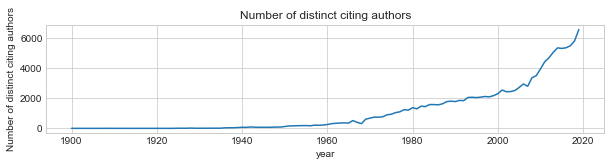

In [11]:
plt.figure(figsize=(10,2))

cc = Counter( cross.fy for cross, count in cits[comb(dtype, 'fy')].items() if count > 0 )
years = range(1900,2020)
plt.plot(
    years,
    [cc[x] for x in years]
)
plt.title("Number of distinct %s" % print_names)
plt.xlabel("year")
plt.ylabel("Number of distinct %s" % print_names)
save_figure( "Number of distinct %s (%s)" % (print_names, database_name) )

# demographic tables (incomplete)

In [12]:
    
death_key = 'death_3'

born = lambda x: x[birth_key]
died = lambda x: x[death_key]

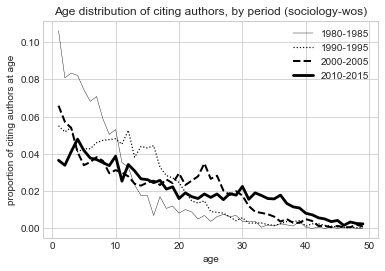

In [13]:
step = 20
lookahead = 5
maxage = 50

arange = range(1,maxage)
decades = [1980,1990,2000,2010]
greys = list(reversed(plt.cm.gray(np.linspace(0,0.7,len(decades)))))


for i,YRLOOK in enumerate(decades):#enumerate(range(1960, 2020, step))
    cited_now = Counter()

    for cross, count in docs[ comb('fy',dtype) ].items():
        if not( YRLOOK <= cross.fy < YRLOOK + lookahead ):
            continue
        if getattr(cross,dtype) not in ysum:
            continue        

        cited_now[ cross.fy - ysum[ getattr(cross,dtype) ][birth_key] ] += 1

    cited = np.array([cited_now[A] for A in arange])
    cited = cited/np.sum(cited)
        
    plt.plot(arange, cited , label="%s-%s" % (YRLOOK, YRLOOK+lookahead), linewidth=(i+0.5)*0.8, color='black', linestyle=linestyles[i] ) #str(YRLOOK+20)[-2:] # linestyle=linestyles[i]
    
#plt.ylim(0,None)
plt.legend()
plt.xlabel("age")
plt.ylabel('proportion of %s at age' % print_names)
plt.title("Age distribution of %s, by period (%s)" % (print_names, database_name))

save_figure("Proportion of documents with citations by %s (%s)" % (dtype, database_name))
plt.show();

# probabilities of death!

In [14]:
np.arange(1960, 2005, 5)

array([1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000])

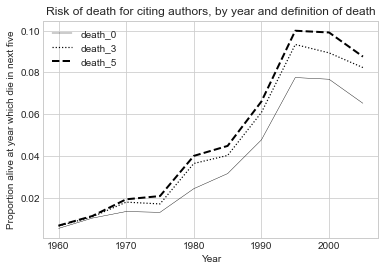

In [15]:
step = 20
lookahead = 5
maxage = 50

decades = list(np.arange(1960, 2005+5, 5))
greys = list(reversed(plt.cm.jet(np.linspace(0,1,len(decades)))))

for i, death_key in enumerate(['death_0', 'death_3', 'death_5']):
    mytrend = []
    for YRLOOK in decades:#enumerate(range(1960, 2020, step))
        cited_now = Counter()

        total_alive_now = len([ _ for x in ysum.values() if x[death_key] is None or x[death_key] >= YRLOOK ])
        total_died_now = len([ _ for x in ysum.values() if x[death_key] is not None and YRLOOK <= x[death_key] < YRLOOK+5 ])
        prop = total_died_now / total_alive_now
        mytrend.append(prop)

    plt.plot(decades, mytrend, label=death_key, linewidth=(i+0.5)*0.8, color='black', linestyle=linestyles[i] ) #str(YRLOOK+20)[-2:] # linestyle=linestyles[i]
    
#plt.ylim(0,None)
plt.legend()
plt.xlabel("Year")
plt.ylabel('Proportion alive at year which die in next five')
plt.title("Risk of death for %s, by year and definition of death" % (print_names))

#save_figure("Proportion of documents with citations by %s (%s)" % (dtype, database_name))
plt.show();

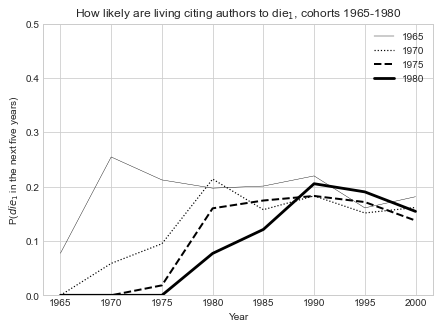

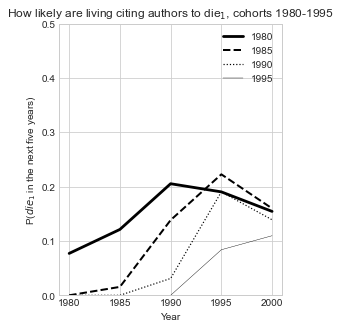

In [16]:
step = 20
lookahead = 5
maxage = 50


greys = list(reversed(plt.cm.jet(np.linspace(0,1,len(decades)))))

# two groups of cohorts
for c_plot in [1965, 1980]:
    
    if c_plot == 1965:
        plt.figure(figsize=(7,5))
    elif c_plot == 1980:
        plt.figure(figsize=(4,5))
    else:
        raise

    cohorts = list(range(c_plot, 2010, 5))[:4]
    decades = list(np.arange(c_plot, 2005, 5))

    for i, cohort in enumerate(cohorts):
        #print('cohort',cohort)
        mytrend = []
        for YRLOOK in decades:#enumerate(range(1960, 2020, step))
            #print('yrlook',YRLOOK)
            cited_now = Counter()

            total_alive_now = len([ 1 for x in ysum.values() if (cohort <= x['first'] <= cohort+10) and (x['death_1'] is None or YRLOOK+5 > x['death_1'] >= YRLOOK) ])
            total_died_now = len([ 1 for x in ysum.values() if (cohort <= x['first'] <= cohort+10) and (x['death_1'] is not None and YRLOOK <= x['death_1'] < YRLOOK+5) ])
            prop = total_died_now / total_alive_now
            mytrend.append(prop)

        # make the 1980 cohort match
        
        if c_plot == 1965:
            plt.plot(decades, mytrend, label=cohort, linewidth=(i+0.5)*0.8, color='black', linestyle=linestyles[i] ) #str(YRLOOK+20)[-2:] # linestyle=linestyles[i]
        elif c_plot == 1980:
            plt.plot(decades, mytrend, label=cohort, linewidth=(3-i+0.5)*0.8, color='black', linestyle=linestyles[3-i] ) #str(YRLOOK+20)[-2:] # linestyle=linestyles[i]
        else:
            raise

    title = "How likely are living %s to die$_1$, cohorts %s-%s" % (print_names, min(cohorts), max(cohorts))

    #plt.ylim(0,None)
    plt.legend()
    plt.xlabel("Year")
    plt.ylabel('P($die_1$ in the next five years)')
    plt.title(title)
    plt.xticks(
        range( c_plot, 2005, 5 )
    )
    plt.ylim(0,0.5)

    save_figure("%s (%s)"% (title, database_name))
    plt.show();

In [17]:
np.sum(cited[:10])

0.3840373679935012

# Tables

In [18]:
from knowknow import save_table_html


# plot number of citing documents, by age

In [19]:
ranges = [(0,5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30)]

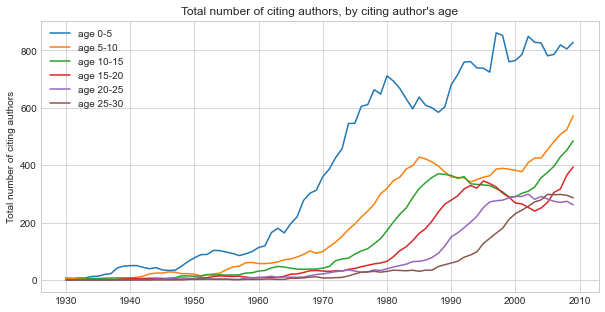

In [20]:
YRLOOKS = range(1930, 2010, 1)

plt.figure(figsize=(10,5))
for i,r in enumerate(ranges): # r is an age range, e.g. 10-15, or 35+
    lablab = "age %s-%s" % r
    #if i+1==len(ranges):
    #    lablab = "age %s+" % r[0]
        
    plt.plot(
        YRLOOKS,
        [
            len(set( 
                getattr(cross,dtype)
                for cross, count in docs[comb(dtype, 'fy')].items() 
                if y <= cross.fy < y+5 and 
                    getattr(cross,dtype) in ysum and
                    r[0] <= cross.fy - ysum[ getattr(cross,dtype) ]['first'] < r[1]
               ))
            for y in YRLOOKS
        ], 
    label=lablab)
    
plt.legend()
plt.ylabel("Total number of %s" % print_names);
plt.title("Total number of %s, by %s's age" % (print_names, print_name));

save_figure("Distinct, by year and %s age (%s)" % (print_name, database_name))

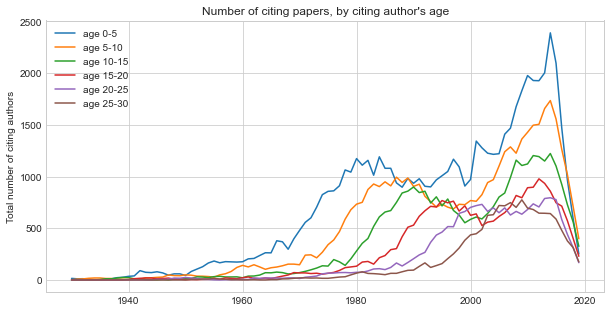

In [21]:
YRLOOKS = range(1930, 2020, 1)

plt.figure(figsize=(10,5))
for i,r in enumerate(ranges): # r is an age range, e.g. 10-15, or 35+
    lablab = "age %s-%s" % r
    #if i+1==len(ranges):
    #    lablab = "age %s+" % r[0]
        
    plt.plot(
        YRLOOKS,
        [
            sum(
                count
                for cross, count in docs[comb(dtype, 'fy')].items() 
                if y <= cross.fy <= y+5 and 
                    getattr(cross,dtype) in ysum and
                    r[0] <= y - ysum[ getattr(cross,dtype) ]['first'] < r[1]
            )
            for y in YRLOOKS
        ], 
    label=lablab)
    
plt.legend()
plt.ylabel("Total number of %s" % print_names);
plt.title("Number of citing papers, by %s's age" % (print_name));

save_figure("Publications, by year and %s age (%s)" % (print_names, database_name))

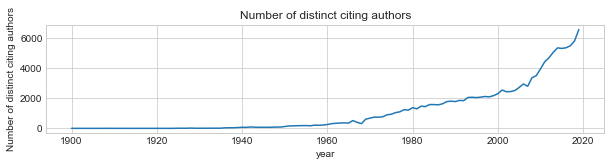

In [22]:
plt.figure(figsize=(10,2))

cc = Counter( cross.fy for cross in cits[comb(dtype, 'fy')] )
years = range(1900,2020)
plt.plot(
    years,
    [cc[x] for x in years]
)
plt.title("Number of distinct %s" % print_names)
plt.xlabel("year")
plt.ylabel("Number of distinct %s" % print_names)
save_figure( "Number of distinct %s (%s)" % (print_names, database_name) )

# Probability of death based on cohort, YRLOOK

The following plot shows the percent of 

In [23]:
def birthdate_pdead(YRLOOK):

    dying_count = defaultdict(lambda:defaultdict(int))

    step = 5

    # first we go through and count how many publications born in each year are dead before YRLOOK

    # loop through entries
    for k, x in ysum.items():
        for dk in definitions_of_death:
            dying_count[dk][(
                (x[birth_key]//step)*step,
                x[dk] is not None and x[dk] < YRLOOK
            )] += 1

    counts = range((YMIN//step)*step,(YMAX//step)*step,step)

    for i,dk in enumerate(definitions_of_death):
        probs = [ 
            dying_count[dk][(c,True)] / (dying_count[dk][(c,True)]+dying_count[dk][(c,False)])     
            if (dying_count[dk][(c,True)]+dying_count[dk][(c,False)]>0) else 0 
            for c in counts 
        ]
        plt.plot(counts,probs,label=dk,linestyle=linestyles[i], color='black')

    plt.xlabel("birth date")
    plt.ylabel("P(dead by %s)" % YRLOOK)
    plt.legend();
    plt.ylim(0,1)
    
    save_figure("Probability of cited %s death by %s, by cohort (%s)" % (print_name, YRLOOK, database_name) )

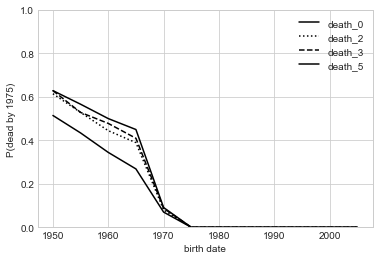

In [24]:
birthdate_pdead(1975)

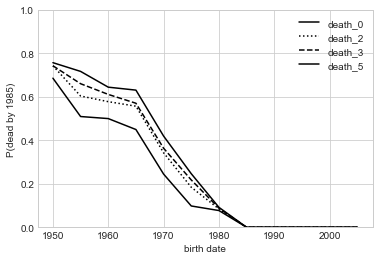

In [25]:
birthdate_pdead(1985)

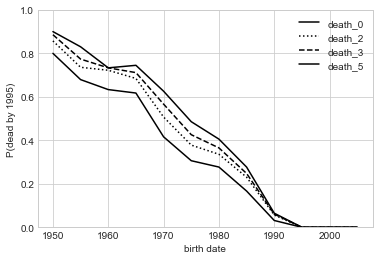

In [26]:
birthdate_pdead(1995)

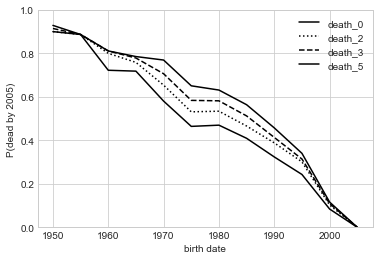

In [27]:
birthdate_pdead(2005)

# age distribution, depending on when you're looking from

In [28]:
YRLOOKS = range(1970,2010,5)
yr_age = defaultdict(lambda: defaultdict(int))

for YRLOOK in YRLOOKS:

    born = lambda x: x[birth_key]
    died = lambda x: x[death_key]

    cits_in_range = defaultdict(int)

    # counting by birth year, in 
    for cross, count in cits[ comb(dtype, 'fy') ].items():
        # cross.fy is the year the item was cited
        
        if getattr(cross,dtype) not in ysum: # skip ones that suck
            continue
        if count == 0:
            continue
        if not( YRLOOK <= cross.fy < YRLOOK+5 ): # must be within my yrlook range
            continue
            
        mybirthd = ysum[ getattr(cross,dtype) ][birth_key] # first time it was cited
        yr_age[ YRLOOK ][ cross.fy - mybirthd ] += 1

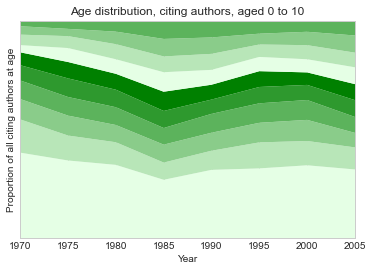

,0,1,2,3,4,5,6,7,8,9
1970,286,111,68,62,51,43,24,35,28,18
1975,418,134,107,100,100,88,75,64,39,43
1980,545,168,128,132,130,118,108,112,93,80
1985,408,120,125,116,119,134,136,110,122,126
1990,479,134,126,132,100,104,104,112,115,116
1995,535,199,150,149,125,121,109,95,83,98
2000,595,198,172,162,123,102,107,115,109,89
2005,593,190,125,137,145,138,145,126,148,126


,0,1,2,3,4,5,6,7,8,9
1970,39%,15%,9%,9%,7%,6%,3%,5%,4%,2%
1975,36%,11%,9%,9%,9%,8%,6%,5%,3%,4%
1980,34%,10%,8%,8%,8%,7%,7%,7%,6%,5%
1985,27%,8%,8%,8%,8%,9%,9%,7%,8%,8%
1990,31%,9%,8%,9%,7%,7%,7%,7%,8%,8%
1995,32%,12%,9%,9%,8%,7%,7%,6%,5%,6%
2000,34%,11%,10%,9%,7%,6%,6%,6%,6%,5%
2005,32%,10%,7%,7%,8%,7%,8%,7%,8%,7%


In [29]:
age_ranges = list(zip(
    range(0,10,1),
    range(1,11,1)
))

# Make data
data = pd.DataFrame({  
    age[0]: [ sum( yr_age[YRLOOK][a] for a in range(*age) ) for YRLOOK in YRLOOKS]
    for age in age_ranges
}, index=YRLOOKS)
 
# We need to transform the data from raw data to percentage (fraction)
data_perc = data.divide(data.sum(axis=1), axis=0)

# Make the plot
plt.stackplot(YRLOOKS,  *[data_perc[a] for a in range(0,10,1)], labels=['age %s' % x for x in range(0,10,1)], colors=sns.light_palette("green"))
#plt.legend(loc='upper left')
plt.margins(0,0)
plt.yticks([-1],[-1])

title = "Age distribution, %s, aged %s to %s" % (print_names, min(age_ranges)[0], max(age_ranges)[1])
plt.title(title)
plt.xlabel("Year")
plt.ylabel("Proportion of all %s at age" % print_names)

save_figure(title)
plt.show()

html = data.to_html()
save_table_html( html, ", ".join([title, 'counts', database_name]) )
display(HTML(html))

data_perc = data_perc.style.format("{:.0%}", na_rep="-")
html = data_perc.render()
save_table_html( html, 
                ", ".join([title, 'percents', database_name]) )
display(HTML(html))

In [30]:
if False:
    plt.xlim((-5,30))
    plt.ylim((0,plt.ylim()[1]*1.2))
    plt.yticks(
        range(0,int(plt.ylim()[1]),1),
        ["%s%%"%x for x in range(0,int(plt.ylim()[1]),1)]
    )
    plt.ylabel("P(Age)")
    plt.xlabel("Age")
    lgnd = plt.legend(fancybox=True, title='in decade', prop={'size': 12})

    for h in lgnd.legendHandles:
        h._sizes = [30]

    plt.xlim((0,15))

    save_figure("Cited %s age distribution, by decade of citation (%s)" % (print_name, database_name))
    #plt.legend()
    plt.show()

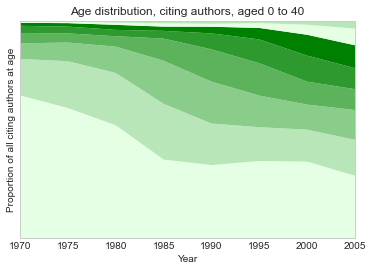

,0,5,10,15,20,25,30,35
1970,578,148,63,42,29,12,7,1
1975,859,309,123,60,45,23,11,4
1980,1103,511,257,102,62,49,22,17
1985,888,628,486,250,87,48,38,27
1990,971,551,555,428,212,88,40,38
1995,1158,506,473,484,357,172,72,34
2000,1250,522,409,373,425,340,164,63
2005,1190,683,566,397,399,436,318,146


,0,5,10,15,20,25,30,35
1970,66%,17%,7%,5%,3%,1%,1%,0%
1975,60%,22%,9%,4%,3%,2%,1%,0%
1980,52%,24%,12%,5%,3%,2%,1%,1%
1985,36%,26%,20%,10%,4%,2%,2%,1%
1990,34%,19%,19%,15%,7%,3%,1%,1%
1995,36%,16%,15%,15%,11%,5%,2%,1%
2000,35%,15%,12%,11%,12%,10%,5%,2%
2005,29%,17%,14%,10%,10%,11%,8%,4%


In [31]:
age_ranges = list(zip(
    range(0,40,5),
    range(5,45,5)
))

# Make data
data = pd.DataFrame({  
    age[0]: [ sum( yr_age[YRLOOK][a] for a in range(*age) ) for YRLOOK in YRLOOKS]
    for age in age_ranges
}, index=YRLOOKS)
 
# We need to transform the data from raw data to percentage (fraction)
data_perc = data.divide(data.sum(axis=1), axis=0)

# Make the plot
plt.stackplot(YRLOOKS,  *[data_perc[a[0]] for a in age_ranges], labels=['age %s-%s' % a for a in age_ranges], colors=sns.light_palette("green"))
#plt.legend(loc='upper left')
plt.margins(0,0)
plt.yticks([-1],[-1])

title = "Age distribution, %s, aged %s to %s" % (print_names, min(age_ranges)[0], max(age_ranges)[1])
plt.title(title)
plt.xlabel("Year")
plt.ylabel("Proportion of all %s at age" % print_names)

save_figure(title)
plt.show()


html = data.to_html()
save_table_html( html, ", ".join([title, 'counts', database_name]) )
display(HTML(html))

data_perc = data_perc.style.format("{:.0%}", na_rep="-")
html = data_perc.render()
save_table_html( html, 
                ", ".join([title, 'percents', database_name]) )
display(HTML(html))

# proportion dead based from each cohort

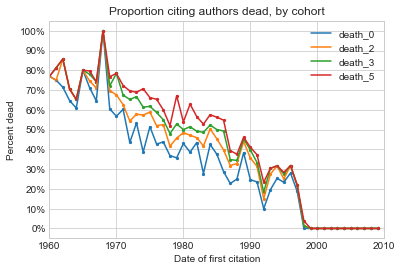

In [32]:
YLOOK = 2000

for death_key in definitions_of_death:

    born = lambda x: x[birth_key]
    died = lambda x: x[death_key]

    years = range(YMIN,YMAX)
    pdied = {
        y: Counter( (died(x) is not None and died(x)<=YLOOK) for x in ysum.values() if x['first']==y ) + 
            Counter( "total" for x in ysum.values() if x['first']==y )
        for y in years
    }

    props = np.array([ pdied[y][True]/pdied[y]['total'] if pdied[y]['total']>0 else np.nan for y in years ])

    plt.plot(
        years,
        props*100,
        label=death_key
    );
    plt.scatter(years,props*100,s=5)
    #plt.errorbar(years,percents,se*100)

plt.title("Proportion %s dead, by cohort" % print_names.lower())
plt.yticks(
    range(0,110,10),
    ["%s%%"%x for x in range(0,110,10)]
)
plt.ylabel("Percent dead")
plt.xlabel("Date of %s" % print_birth.lower())

plt.xlim(1960,YMAX)


plt.legend()

save_figure("Proportion of %s dead by %s, by cohort (%s)" % (print_names.lower(), YLOOK, database_name))
plt.show()

In [33]:
# this analysis doesn't make sense for terms or people
if dtype == 'c':

    cc = Counter(x['first'] - x['pub'] for x in ysum.values() )
    x = range(0,20,1)
    plt.bar(
        x,
        [cc[xx] for xx in x],
        1,
        alpha=0.1
    )

    plt.bar(
        x,
        [cc[xx] for xx in x],
        1,
        color='black',
        fill=False,
        linestyle='-'
    )

    ys = range(0,70000, 10000)
    plt.yticks(
        ys,
        ["%dk"%(x//1000) for x in ys]
    )

    plt.xticks(
        range(0,21,1)
    );

    plt.grid(False, axis='x')

    plt.ylabel("Number of works")
    plt.xlabel("Number of years until %s"%print_birth.lower());

    save_figure("Sleeping beauties - between pub and first (%s)"%(database_name))